# Evolutionary Algorithms (Part 2)

In this chapter we take a closer look at some of the search operators and algorithmic choices that we took for granted so far. In particular, we reconsider selection, crossover, mutation, and the topology of the population itself.

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.utils import io
from statistics import mean

We will start by considering the one max problem again, where a solution is a vector of length _n_, consisting of binary numbers.

In [2]:
n = 20

To keep code examples simple, we will not use our wrapper class but lists again.

In [3]:
def get_random_solution():
    individual = [random.choice([0,1]) for _ in range(n)]
    return individual

The fitness function as well as variation operators are still the same:

In [4]:
def get_fitness(solution):
    return sum(solution)

We start with the operators that we have used previously.

In [5]:
def mutate(individual):
    P_mutate = 1/len(individual)
    copy = individual[:]
    for position in range(len(individual)):
        if random.random() < P_mutate:
            copy[position] = 1 - copy[position]
    return copy

In [6]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]
    return offspring1, offspring2

The first selection operator we considered was tournament selection:

In [7]:
tournament_size = 3
def tournament_selection(population, replacement=False):
    if replacement:
        candidates = random.choices(population, k = tournament_size)
    else:
        candidates = random.sample(population, tournament_size)
        
    winner = max(candidates, key = lambda x: get_fitness(x))
    return winner

A general problem in evolutionary search is finding the right balance between exploration and exploitation. Using the wrong operators may lead to premature convergence, or the search may never converge at all at an optimum. As a first step towards understanding what is happening inside the population of a genetic algorithm, we will consider the _average fitness_ of the population as well as the _diversity_ within the population in addition to the best fitness value we already tracked in the past. For this, we first define the difference between two individuals as the hamming distance between the vector representations:

In [8]:
def hamming_distance(individual1, individual2):
    return sum(c1 != c2 for c1, c2 in zip(individual1, individual2))

We can now calculate an overall population diversity as the sum of pairwise hamming distances for all pairs of individuals in the population.

In [9]:
def pairwise_distance(population):
    distances = 0
    for i in range(len(population)-1):
        for j in range(i, len(population)):
           distances += hamming_distance(population[i], population[j]) 
    return distances

We need to set the parameters of our genetic algorithm first:

In [10]:
population_size = 20
P_xover   = 0.7
max_steps = 1000
selection = tournament_selection
crossover = singlepoint_crossover

# These lists track values throughout the evolution
# so we can compare the behaviour of different operators
fitness_values = []
diversity_values = []
mean_fitness_values = []

In the lecture we discussed that there are many different variations of all the search operators involved in a genetic algorithm. We will now look at a couple of relevant search operators.

## Survivor Selection

Most evolutionary algorithms use a fixed population size, so we need a way of going from (parents + offspring) to the next generation. 
- In age-based selection one usually produces as many offspring as there are parents, and then replaces the parents with the offspring. 
- In fitness-based selection, we rank the parents and the offspring, and take the best of all.

We saw both versions last time in the context of evolution strategies, but can also create versions of a genetic algorithm. In a generational genetic algorithm the offspring replaces the parents, while in a steady state genetic algorithm we apply fitness-based survivor selection.

Elitism is a special case, where the best individuals of the population always survive, while other means are used for the rest of the population. We implement a simple version of elitism by simply ranking the population by diversity and taking the top `elite_size` elements:

In [11]:
elite_size = int(population_size * 0.05)

def elitism(population):
    population.sort(key=lambda k: get_fitness(k), reverse=True)
    return population[:elite_size]

Let's revisit the standard genetic algorithm with a generational selection model, integrated with elitism:

In [12]:
def ga():
    population = [get_random_solution() for _ in range(population_size)]
    fitness_values.clear()

    # This could probably be written in a single line, but let's keep it explicit
    best_fitness = -1
    for p in population:
        fitness = get_fitness(p)
        if fitness > best_fitness:
            best_fitness = fitness
        fitness_values.append(best_fitness)

    diversity_values.append(pairwise_distance(population))
    mean_fitness_values.append(mean([get_fitness(x) for x in population]))

    while len(fitness_values) < max_steps:

        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1[:], parent2[:]

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            
            fitness1, fitness2 = get_fitness(offspring1), get_fitness(offspring2)

            if fitness1 > best_fitness:
                best_fitness = fitness1
            fitness_values.append(best_fitness)
            if fitness2 > best_fitness:
                best_fitness = fitness2
            fitness_values.append(best_fitness)
            
            new_population += [offspring1, offspring2]

        population = new_population
        diversity_values.append(pairwise_distance(population))
        mean_fitness_values.append(mean([get_fitness(x) for x in population]))

    return max(population, key=lambda k: get_fitness(k))

The alternative was the steady state genetic algorithm, where we select two parents, derive their offspring, and then do fitness-based survivor selection:

In [13]:
def steadystatega():
    population = [get_random_solution() for _ in range(population_size)]
    best_fitness = -1
    fitness_values.clear()
    
    for p in population:
        fitness = get_fitness(p)
        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = p
        fitness_values.append(best_fitness)
    diversity_values.append(pairwise_distance(population))
    mean_fitness_values.append(mean([get_fitness(x) for x in population]))
    
    while len(fitness_values) < max_steps:                
        parent1 = selection(population)
        parent2 = selection(population)
        
        p1 = population.index(parent1)
        p2 = population.index(parent2)

        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1[:], parent2[:]

        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)
        
        best1, best2 = sorted([parent1, parent2, offspring1, offspring2], key=lambda x: get_fitness(x), reverse=True)[:2]
        population[p1] = best1
        population[p2] = best2

        fitness1, fitness2 = get_fitness(best1), get_fitness(best2)

        if fitness1 > best_fitness:
            best_fitness = fitness1
        fitness_values.append(best_fitness)
        if fitness2 > best_fitness:
            best_fitness = fitness2
        fitness_values.append(best_fitness)
        
        # To make plots comparable with the generational GA
        if len(fitness_values) % population_size == 0:
            diversity_values.append(pairwise_distance(population))
            mean_fitness_values.append(mean([get_fitness(x) for x in population]))
            
    return best_solution

Note that there are further possibilities for variation here: Instead of replacing the selected parents in the population, we could select other individuals (e.g., the worst individuals).

To consider the effects on diversity, let's compare diversity and fitness throughout one run each. We'll increase `n` to make the problem slightly more challenging.

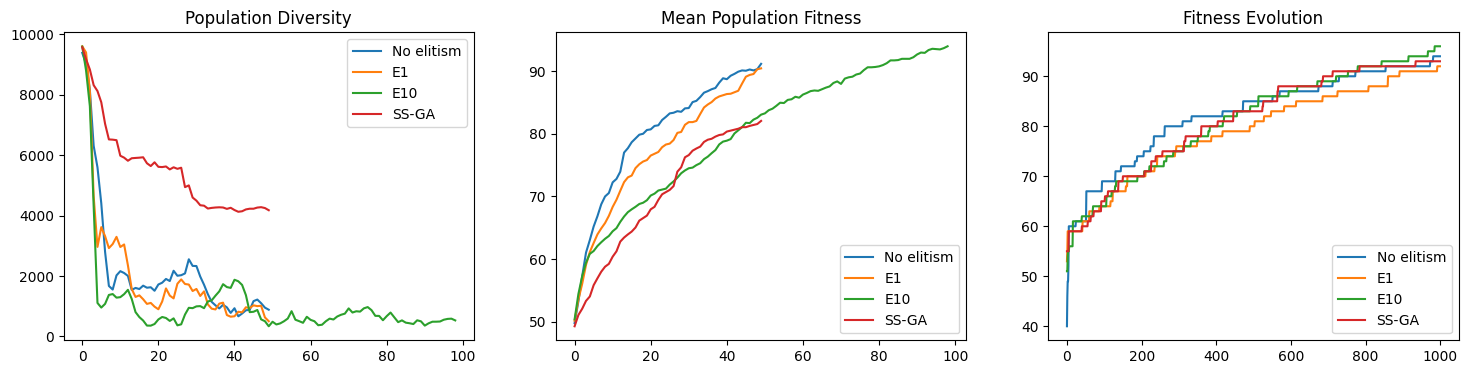

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
max_steps = 1000
population_size = 20

with io.capture_output() as captured: 
    elite_size = 0
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    ga()
    axes[0].plot(diversity_values, label=f"No elitism")
    axes[1].plot(mean_fitness_values, label=f"No elitism")
    axes[2].plot(fitness_values, label=f"No elitism")

    elite_size = 1
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    ga()
    axes[0].plot(diversity_values, label=f"E1")
    axes[1].plot(mean_fitness_values, label=f"E1")
    axes[2].plot(fitness_values, label=f"E1")
    
    elite_size = 10
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    ga()
    axes[0].plot(diversity_values, label=f"E10")
    axes[1].plot(mean_fitness_values, label=f"E10")
    axes[2].plot(fitness_values, label=f"E10")
    
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    steadystatega()
    axes[0].plot(diversity_values, label=f"SS-GA")
    axes[1].plot(mean_fitness_values, label=f"SS-GA")
    axes[2].plot(fitness_values, label=f"SS-GA")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Fitness Evolution')
axes[2].legend()
plt.show()

As usual results may vary between runs, since these are randomised algorithms. However, a general trend we should see in the above plots is that the population diversity of the steady state GA reduces much slower than in a generational GA, and also the average fitness value in the population remains lower. The large elitism size of `10` means that the algorithm can run more generations with the same number of fitness evaluations, which is why it continues longer than the others in the first two plots. A small elitism size tends to generally lead to a better average fitness in this configuration. The best performing version will differ between runs.

## Parent Selection

A major difference between the evolution strategies we considered initially and the canonical genetic algorithm we looked at afterwards is the parent selection strategy. In classical evolution strategies all μ (mu) parents are involved in recombination, and the survivor selection is what drives the selective pressure. In genetic algorithms, instead, the parent selection applies selective pressure. 

We started off with tournament selection because it is the quickest to implement. A traditionally more common variant is fitness proportionate selection, where the probability of an individual to be selected is proportional to its fitness value. The selection thus first calculates the total fitness sum, and then probabilistically chooses an individual by sampling a number in the range between 0 and the total fitness sum. An important requirement is that the population is sorted by fitness values, starting with the best individual (largest fitness).  This selection operator is also known as _roulette wheel selection_.

In our simple implementation, we create a list of tuples `fitness_list` that stores individuals with their fitness. Obviously, there's some redundant fitness calculations here; in practice one would cache fitness values.

In [15]:
def roulette_selection(population):
    fitness_sum = sum([get_fitness(x) for x in population])
    population.sort(key=lambda x: get_fitness(x), reverse=True)
    pick = random.uniform(0, fitness_sum)
    current = 0
    for x in population:
        current += get_fitness(x)
        if current > pick:
            return x

To evaluate this, let's create a simple example population for `n=5` with individuals with fitness 5, 4, 3, 2, 1, and 0:

In [16]:
example_population = [ [1,1,1,1,1], [0,1,1,1,1], [0,0,1,1,1], [0,0,0,1,1], [0,0,0,0,1], [0,0,0,0,0]  ]

Applying this selection operator will more likely select the best individual(s) (but may select worse individuals as well). We can do a simple experiment by sampling repeatedly from our `example_population` and looking at the resulting histogram:

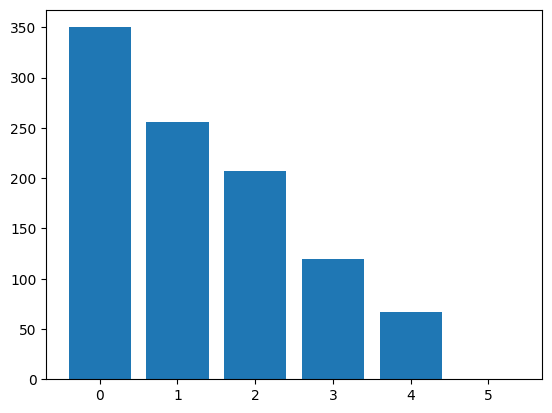

In [17]:
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = roulette_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

A problem with fitness proportionate selection is that individuals that have a much better fitness value will dominate the selection. For example, let's skew our example population:

In [18]:
example_population = [ [1,1,1,1,1], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,0] ]

In this population, the first individual has fitness value 5, while the other individuals have fitness 1 and 0. The sum of fitness values is 9, and so the first individual has a probability of 56% of being selected:

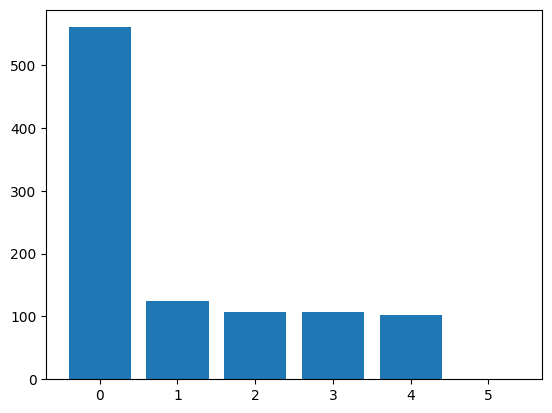

In [19]:
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = roulette_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

Tournament selection, which we implemented earlier, suffers less from this problem. In tournament selection, we can adjust the _selective pressure_ by adjusting the tournament size. With our example population of size 3, a tournament size of 2 without replacement would imply a 67% chance of the best of the three individuals being selected:

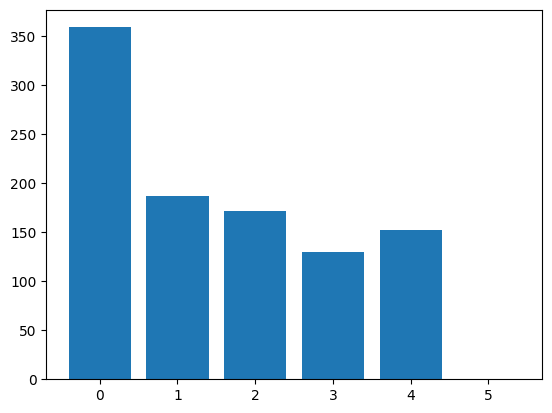

In [20]:
tournament_size = 2

counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = tournament_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

Let's also compare this to the population with a more equal spread:

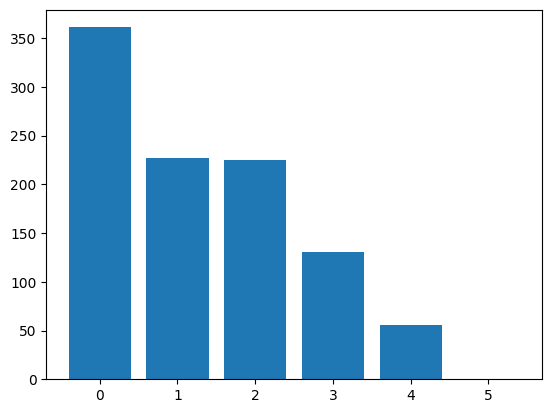

In [21]:
example_population = [ [1,1,1,1,1], [0,1,1,1,1], [0,0,1,1,1], [0,0,0,1,1], [0,0,0,0,1], [0,0,0,0,0]  ]

counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = tournament_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

To see the effects of the tournament size on the selection, let's repeat this with a larger tournament size, which means higher selective pressure:

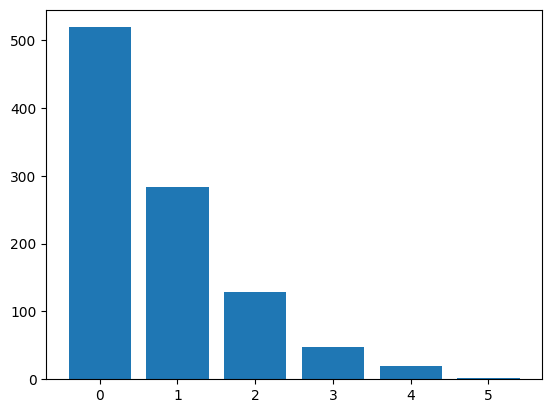

In [22]:
tournament_size = 4

counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = tournament_selection(example_population, replacement=True)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

Even with small tournament size the worst individual was not chosen in any of these cases. The reason is that we are using tournament selection _without_ replacement. If we pick any two individuals out of `example_population`, the individual with fitness 0 will _always_ be worse. If we use replacement, then there is a chance that the worst individual gets selected:

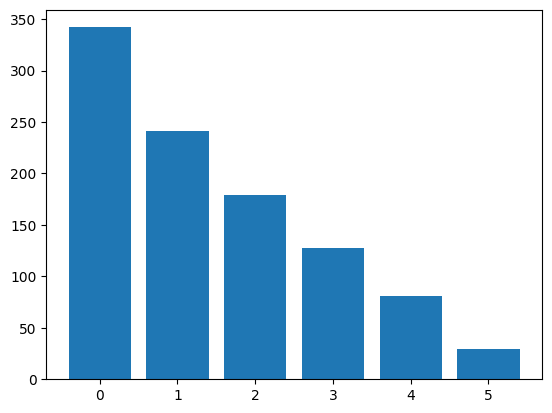

In [23]:
tournament_size = 2

counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = tournament_selection(example_population, replacement=True)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

We can also observe the effects of the selective pressure throughout evolution.

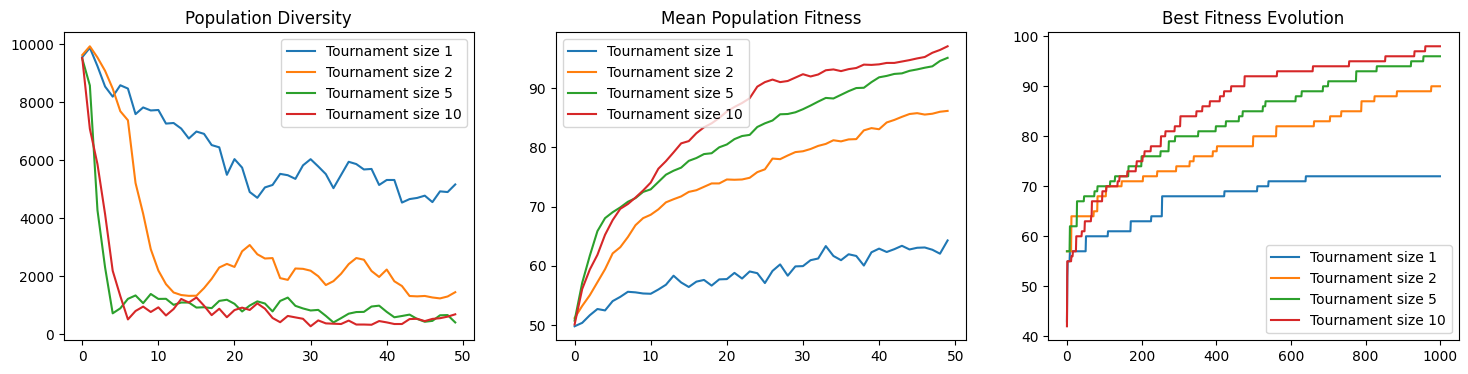

In [24]:
n = 100
from IPython.utils import io

elite_size = 1
selection = tournament_selection
tournament_sizes = [1, 2, 5, 10]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
for tournament_size in tournament_sizes:
    fitness_values, diversity_values, mean_fitness_values = [], [], []
    with io.capture_output() as captured: 
        ga()
    axes[0].plot(diversity_values, label=f"Tournament size {tournament_size}")
    axes[1].plot(mean_fitness_values, label=f"Tournament size {tournament_size}")
    axes[2].plot(fitness_values, label=f"Tournament size {tournament_size}")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

Too little selective pressure (e.g., tournament size of 1) tends to be bad. Very large tournaments might be too eager (which is not so much of a problem in one max though).

Should we use fitness proportionate selection or tournament selection?

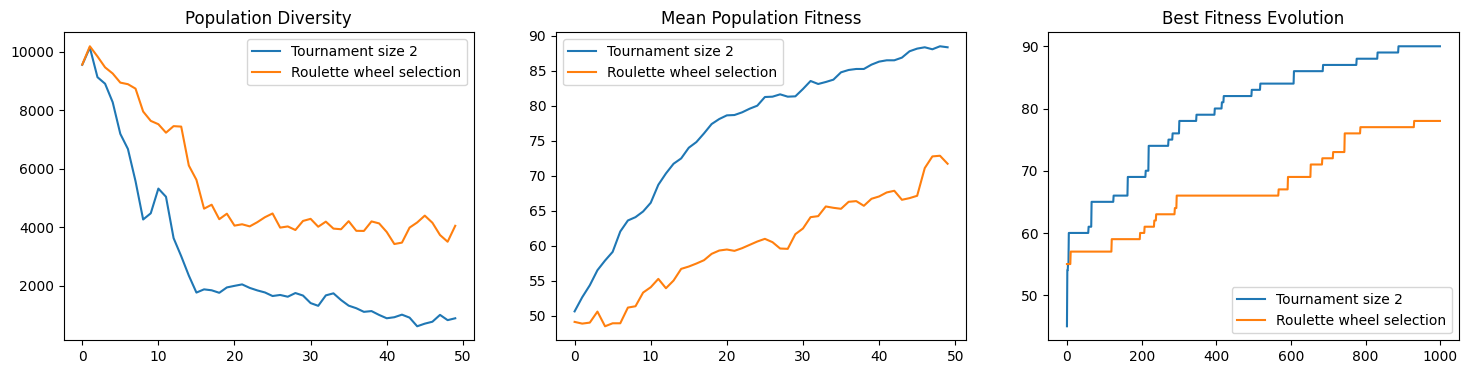

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
with io.capture_output() as captured: 
    fitness_values = []
    diversity_values = []
    mean_fitness_values = []
    selection = tournament_selection
    tournament_size = 2
    ga()
    axes[0].plot(diversity_values, label=f"Tournament size {tournament_size}")
    axes[1].plot(mean_fitness_values, label=f"Tournament size {tournament_size}")
    axes[2].plot(fitness_values, label=f"Tournament size {tournament_size}")

    selection = roulette_selection
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Roulette wheel selection")
    axes[1].plot(mean_fitness_values, label=f"Roulette wheel selection")
    axes[2].plot(fitness_values, label=f"Roulette wheel selection")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

An alternative selection operator is _rank selection_, which is similar to fitness proportionate selection, except that the probability is calculated based on the _rank_ in the population sorted by fitness, rather than the actual fitness value.

In [26]:
rank_bias = 2
def rank_selection(population):
    population.sort(key=lambda c: get_fitness(c), reverse=True)
    
    individuals = []
    N = len(population)
    for i in range(N):
        f2 = rank_bias - (2 * i * (rank_bias - 1))/(N - 1)
        individuals.append((population[i], f2))

    # Now implement fitness proportionate selection using the f2 values
    fitness_sum = sum([f for (c, f) in individuals])
    pick = random.uniform(0, fitness_sum)
    current = 0
    for (chromosome, fitness) in individuals:
        current += fitness
        if current > pick:
            return chromosome

The rank bias, which is in the range `[1,2]` allows us to adjust the selective pressure.

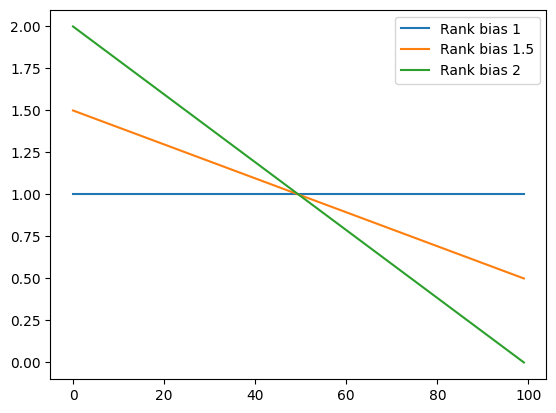

In [27]:
N = 100
for rank_bias in [1, 1.5, 2]:
    plt.plot([rank_bias - (2 * i * (rank_bias - 1)) / (N - 1) for i in range(100)], label = f"Rank bias {rank_bias}")
plt.legend()

With a bias of `2`, the worst individual has a 0% chance of being selected:

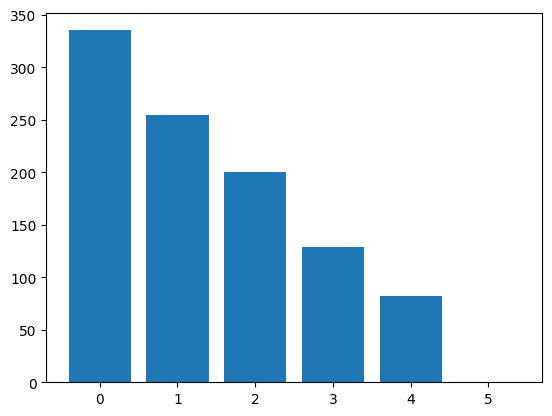

In [28]:
rank_bias = 2

example_population = [ [1,1,1,1,1], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,0] ]
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = rank_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

With a bias of `1`, all individuals have the same probability of being selected:

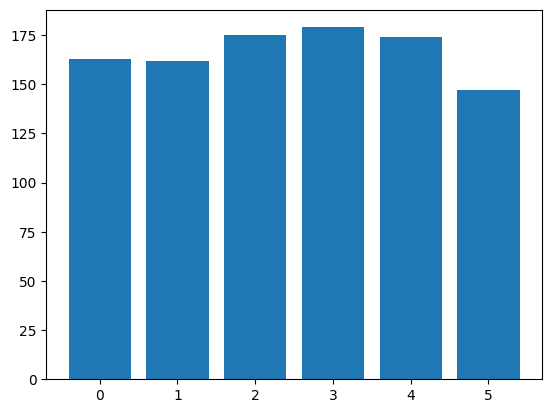

In [29]:
rank_bias = 1

example_population = [ [1,1,1,1,1], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,0] ]
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = rank_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

We will select a reasonable default for the selective pressure:

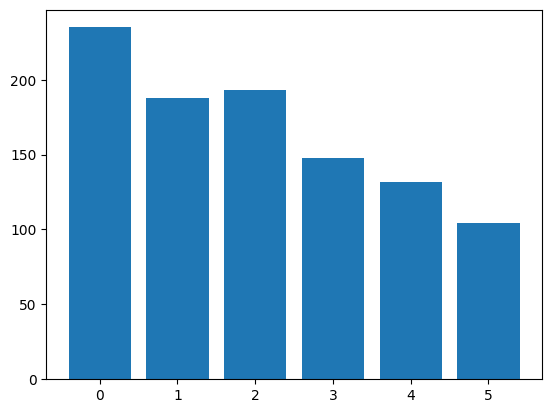

In [30]:
rank_bias = 1.4

example_population = [ [1,1,1,1,1], [0,1,0,0,0], [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,0] ]
counts = {x: 0 for x in range(len(example_population))}

for i in range(1000):
    selected = rank_selection(example_population)
    index = example_population.index(selected)
    counts[index] = counts[index] + 1
    
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()));

We can again observe the effects of the rank bias on the evolution:

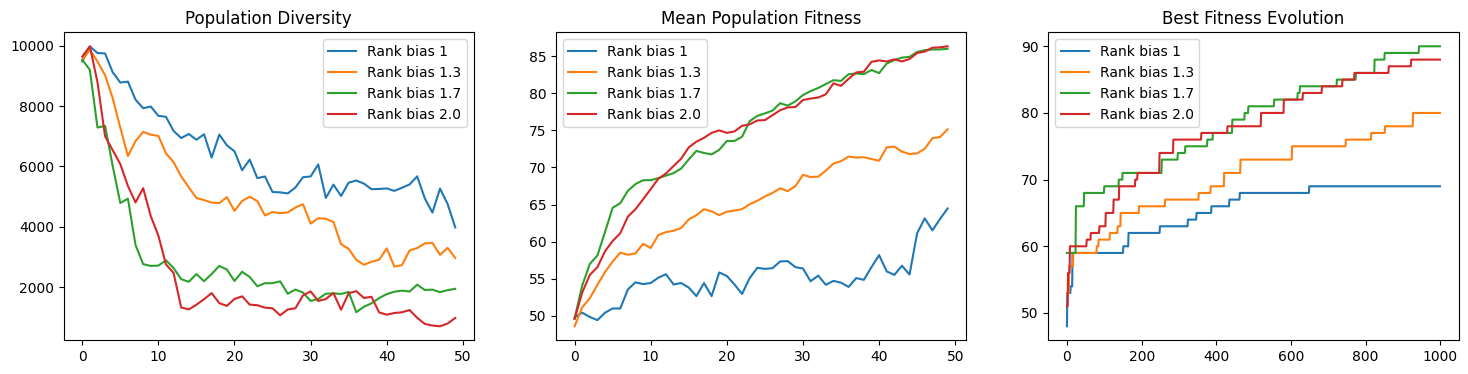

In [31]:
from IPython.utils import io
selection = rank_selection
rank_biases = [1, 1.3, 1.7, 2.0]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
for rank_bias in rank_biases:
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    with io.capture_output() as captured: 
        ga()
    axes[0].plot(diversity_values, label=f"Rank bias {rank_bias}")
    axes[1].plot(mean_fitness_values, label=f"Rank bias {rank_bias}")
    axes[2].plot(fitness_values, label=f"Rank bias {rank_bias}")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

Some variants of genetic algorithms use selection where each individual has the same chance of being selected. Although this removes selection pressure, this is usually compensated with a strong fitness-based survivor selection mechanism.

In [32]:
def uniform_selection(population):
    return random.choice(population)

We would not usually use uniform selection without some other survival selection, but to see what the effects on the search are, let's put all the options together in one experiment.

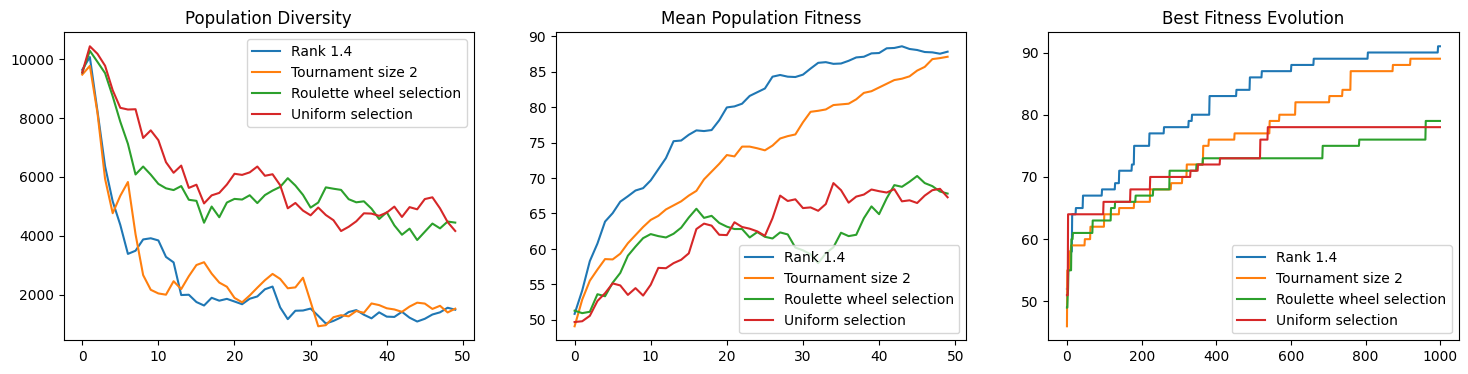

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
with io.capture_output() as captured: 
    rank_bias = 1.4
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    selection = tournament_selection
    tournament_size = 2
    ga()
    axes[0].plot(diversity_values, label=f"Rank {rank_bias}")
    axes[1].plot(mean_fitness_values, label=f"Rank {rank_bias}")
    axes[2].plot(fitness_values, label=f"Rank {rank_bias}")

    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    selection = tournament_selection
    tournament_size = 2
    ga()
    axes[0].plot(diversity_values, label=f"Tournament size {tournament_size}")
    axes[1].plot(mean_fitness_values, label=f"Tournament size {tournament_size}")
    axes[2].plot(fitness_values, label=f"Tournament size {tournament_size}")

    selection = roulette_selection
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Roulette wheel selection")
    axes[1].plot(mean_fitness_values, label=f"Roulette wheel selection")
    axes[2].plot(fitness_values, label=f"Roulette wheel selection")

    selection = uniform_selection
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Uniform selection")
    axes[1].plot(mean_fitness_values, label=f"Uniform selection")
    axes[2].plot(fitness_values, label=f"Uniform selection")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

Survivor selection and parent selection are not independent: As an example, let's consider the effects of selective pressure on the generational GA and the steady state GA. We'll run tournament selection with two different tournament sizes to represent reasonablwe and high selective pressure.

With high selective pressure, the steady state GA maintains very high diversity, even though the best fitness improves reasonably over time. The reason is that with a large tournament size of 6 (with a population size of 20) the parent selection will repeatedly select the same few individuals with a high probability. If the result leads to an improvement, these are replaced but will be picked again with high probability afterwards, while large parts of the population (worse individuals that keep losing tournaments) will simply remain unchanged. This is also reflected by the lower average fitness in the population. For the generational GA the high selective pressure has the opposite effect: The population loses diversity very quickly, because most offspring will be produced from the same few parents. For one max, this doesn't appear to be a bad thing though.

## Alternative Crossover Operators

Our crossover operator so far only considers a single point for crossing two individuals. While this is the most common variant in practice, there is one potential downside: Only locally neighbouring genetic material is preserved; if a parent has relevant genes at the beginning and the end of the chromosome, these will not be inherited to the offspring directly. One way to circumvent this is by defining more than one crossover point. For example, we can define a two-point crossover operator:

In [34]:
def twopoint_crossover(parent1, parent2):
    pos1 = random.randint(1, len(parent1))
    pos2 = random.randint(pos1, len(parent1))
    offspring1 = parent1[:pos1] + parent2[pos1:pos2] + parent1[pos2:]
    offspring2 = parent2[:pos1] + parent1[pos1:pos2] + parent2[pos2:]
    return offspring1, offspring2


In [35]:
parent1 = [0,0,0,0,0,0,0,0,0,0]
parent2 = [1,1,1,1,1,1,1,1,1,1]

In the single point crossover, the offspring of `parent1` and `parent2` will _always_ be either a sequence of `0` followed by a sequence of `1`, or vice versa:

In [36]:
singlepoint_crossover(parent1, parent2)

([0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In the two point crossover, there will be some variation:

In [37]:
twopoint_crossover(parent1, parent2)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

It is not common to increase the number of crossover points beyond two, but instead of more variation is required, it is simply possible to _uniformly_ select genes from either of the parents, resulting in _uniform crossover_:

In [38]:
def uniform_crossover(parent1, parent2):
    offspring1 = []
    offspring2 = []
    for pos in range(len(parent1)):
        if random.choice([True, False]):
            offspring1.append(parent1[pos])
            offspring2.append(parent2[pos])
        else:
            offspring1.append(parent2[pos])
            offspring2.append(parent1[pos])
    return offspring1, offspring2

Applying this to `parent1` and `parent2` from above, we will see offspring consisting of more variation in `1`s and `0`s, but these will always be chosen from parents and not random:

In [39]:
uniform_crossover(parent1, parent2)

([1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

The importance and influence of the crossover operator on the search is part of active research, and also depends on the problem we are trying to solve. To see whether there are any benefits to using crossover on our one max example, we can conduct a _headless chicken_ test: During crossover, we use a randomly generated individual as one of the parents. If the search still performs as well, then the crossover operator actually just serves as a kind of macro-mutation. If the search no longer performs as well, then it is the actual combination of parent genetic material that leads to an improvement.

In [40]:
def chicken_crossover(parent1, parent2):
    offspring1 = []
    offspring2 = []
    parent2 = get_random_solution()
    for pos in range(len(parent1)):
        if random.choice([True, False]):
            offspring1.append(parent1[pos])
            offspring2.append(parent2[pos])
        else:
            offspring1.append(parent2[pos])
            offspring2.append(parent1[pos])
    return offspring1, offspring2

We will run the usual combination of experiments and analyses:

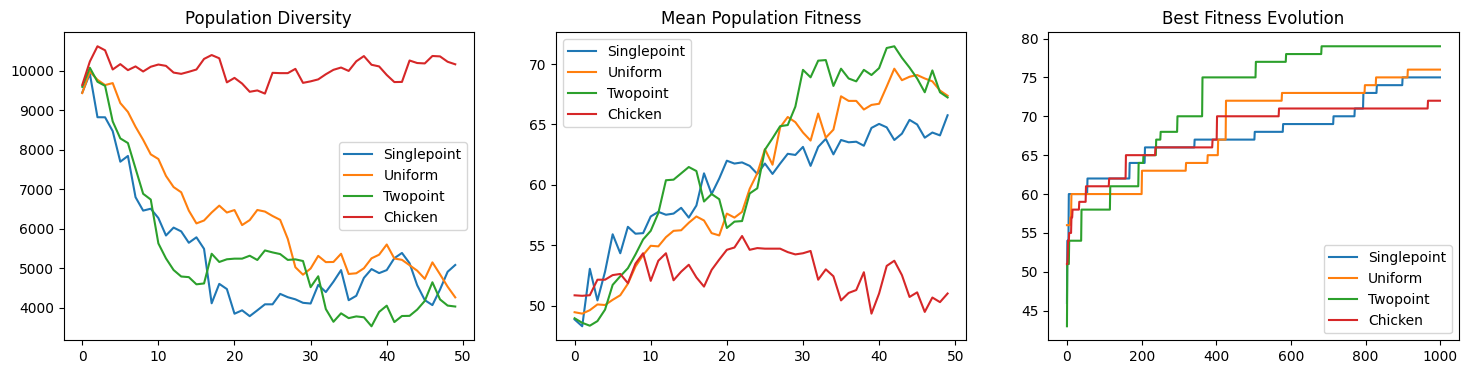

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
with io.capture_output() as captured: 
    crossover = singlepoint_crossover
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Singlepoint")
    axes[1].plot(mean_fitness_values, label=f"Singlepoint")
    axes[2].plot(fitness_values, label=f"Singlepoint")

    crossover = uniform_crossover
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Uniform")
    axes[1].plot(mean_fitness_values, label=f"Uniform")
    axes[2].plot(fitness_values, label=f"Uniform")
    
    crossover = twopoint_crossover
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Twopoint")
    axes[1].plot(mean_fitness_values, label=f"Twopoint")
    axes[2].plot(fitness_values, label=f"Twopoint")
    
    crossover = chicken_crossover
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"Chicken")
    axes[1].plot(mean_fitness_values, label=f"Chicken")
    axes[2].plot(fitness_values, label=f"Chicken")

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

This experiment just conducts a single run, and as usual we need to conduct an experiment with repetitions in order to draw conclusions. However, what most likely shows is that the headless chicken test leads to substantially worse results, while the uniform crossover tends to produce the best results. Consequently, it seems that crossover actually is useful for our problem.

## Mutation Operators

The mutation operator we considered so far flips each bit in a sequence of length $n$ with a probability of $1/n$. To be able to configure our genetic algorithm with alternative mutation operators, let's redefine this operator in a differently named function.

In [42]:
def avg_mutate(individual):
    P_mutate = 1/len(individual)
    copy = individual[:]
    for position in range(len(individual)):
        if random.random() < P_mutate:
            copy[position] = 1 - copy[position]
    return copy

One of the reasons we used this operator so far was that it implicitly defines a mutation probability and we had one less parameter to worry about. However, when considering alternative operators, we will require a probability for applying mutation. This probability is usually fairly small.

In [43]:
P_mutate = 0.01

A basic alternative operator would be to flip a single bit, with probability `P_mutate`.

In [44]:
def mutate1(individual):
    copy = individual[:]
    if random.random() < P_mutate:
        position = random.randint(0, len(copy) - 1)
        copy[position] = 1 - copy[position]
    return copy 

The scope for different operators on our bitvector representation is limited. Let's consider an alternative where we flip multiple bits at the same time.

In [45]:
def mutate10(individual):
    copy = individual[:]
    if random.random() < P_mutate:
        for _ in range(10):
            position = random.randint(0, len(copy) - 1)
            copy[position] = 1 - copy[position]
    return copy

Given these three mutation operators, we can now run some comparative experiments again.

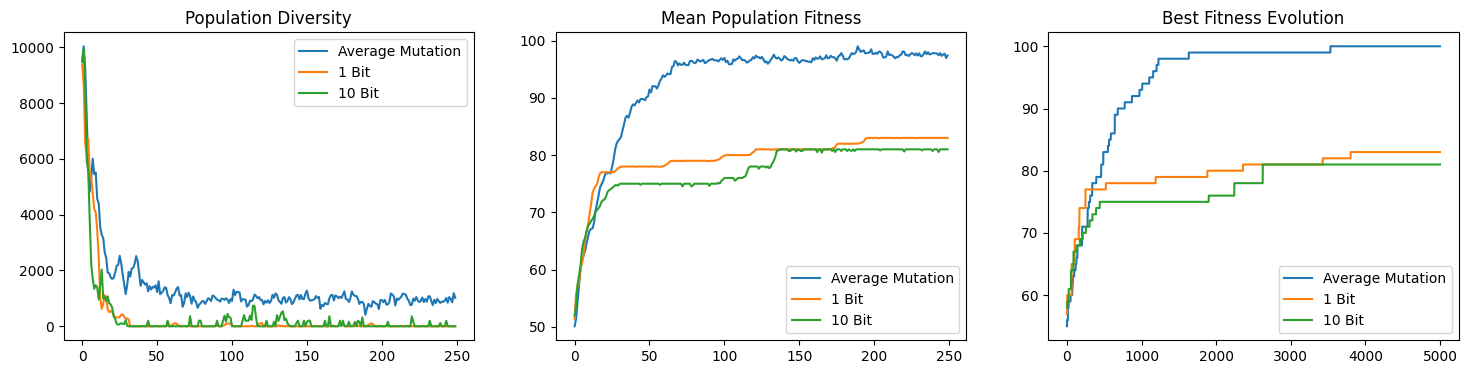

In [46]:
crossover = singlepoint_crossover
selection = tournament_selection
tournament_size = 2

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
max_steps = 5000
with io.capture_output() as captured: 
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    mutate = avg_mutate
    ga()
    axes[0].plot(diversity_values, label=f"Average Mutation")
    axes[1].plot(mean_fitness_values, label=f"Average Mutation")
    axes[2].plot(fitness_values, label=f"Average Mutation")

    mutate = mutate1
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"1 Bit")
    axes[1].plot(mean_fitness_values, label=f"1 Bit")
    axes[2].plot(fitness_values, label=f"1 Bit")
    
    mutate = mutate10
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"10 Bit")
    axes[1].plot(mean_fitness_values, label=f"10 Bit")
    axes[2].plot(fitness_values, label=f"10 Bit")
    

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

Mutating each bit with a probability of $1/n$ is beneficial for the diversity. Comparing the operators that flip 1 and 10 bits, we typically can observe that the 10 bit flip makes larger jumps in fitness improvements, but towards the end of the search it will struggle to home in on a solution as it flips _too much_. 

## Cellular Genetic Algorithms

The last aspect of the genetic algorithm we will consider is the population: The population is usually a multiset, and we mostly implemented it as a list to impose an order on individuals. A cellular evolutionary algorithm imposes a topology on the population. During reproduction, an individual is only allowed to mate with its neighbours, as defined by the topology (commonly rings, grids, or two-dimensional torus graphs).

Let's put our population into a grid, i.e. a two-dimensional list. Let's assume we consider only the 4-neighbourhood (von Neumann neighbourhood) during selection, then we randomly select one of these 4 neighbours and the selected position itself:

In [47]:
def grid_selection(population, row, col):
    neighbours = []
    for dx in [-1, 1]:
        if row + dx >= 0 and row + dx < len(population):
            neighbours.append(population[row + dx][col])
    for dy in [-1, 0, 1]:
        if col + dy >= 0 and col + dy < len(population):
            neighbours.append(population[row][col + dy])

    return random.choice(neighbours)

The genetic algorithm needs to be modified such that the population is a properly initialised grid, and then uses the `grid_selection` we just defined:

In [48]:
grid_size = 5

In [49]:
def cellular_ga():
    fitness_values.clear()
    population = [[get_random_solution() for _ in range(grid_size)] for _ in range(grid_size)]

    diversity_values.append(pairwise_distance([y for x in population for y in x]))
    mean_fitness_values.append(mean([get_fitness(x) for x in [y for x in population for y in x]]))

    best_fitness = -1
    for p in [y for x in population for y in x]:
        fitness = get_fitness(p)
        if fitness > best_fitness:
            best_fitness = fitness
        fitness_values.append(best_fitness)
        
    while len(fitness_values) < max_steps:
        new_population = []
        for row in range(grid_size):
            new_population.append([])
            for col in range(grid_size):
                parent1 = grid_selection(population, row, col)
                parent2 = grid_selection(population, row, col)

                if random.random() < P_xover:
                    offspring1, offspring2 = crossover(parent1, parent2)
                else:
                    offspring1, offspring2 = parent1[:], parent2[:]

                offspring = mutate(random.choice([offspring1, offspring2]))

                if get_fitness(offspring) >= get_fitness(population[row][col]):
                    new_population[row].append(offspring)
                else:
                    new_population[row].append(population[row][col])  
                
                if get_fitness(offspring) > best_fitness:
                    best_fitness = get_fitness(offspring)
                fitness_values.append(best_fitness)

        population = new_population
        
        diversity_values.append(pairwise_distance([y for x in population for y in x]))
        mean_fitness_values.append(mean([get_fitness(x) for x in [y for x in population for y in x]]))

    return max([y for x in population for y in x], key=lambda k: get_fitness(k))

When producing the next generation the cellular GA iterates over the grid, and produces an offspring at each grid location using only the neighbourhood for reproduction. We have implemented an elitist approach where the grid location is only replaced with the offspring if the offspring has the same or better fitness.

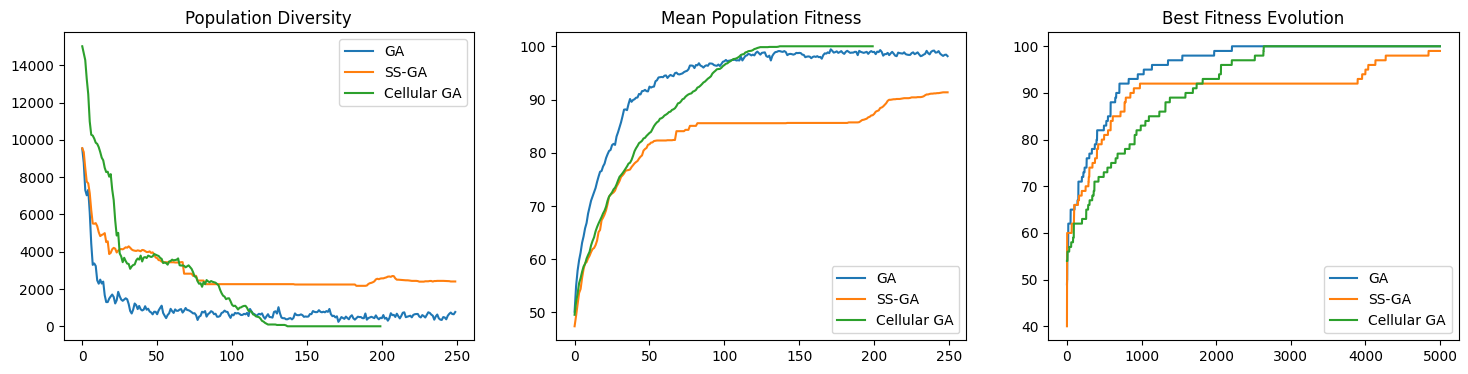

In [50]:
mutate = avg_mutate
crossover = singlepoint_crossover
selection = tournament_selection
tournament_size = 3

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
n = 100
max_steps = 5000
with io.capture_output() as captured: 
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    ga()
    axes[0].plot(diversity_values, label=f"GA")
    axes[1].plot(mean_fitness_values, label=f"GA")
    axes[2].plot(fitness_values, label=f"GA")

    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    steadystatega()
    axes[0].plot(diversity_values, label=f"SS-GA")
    axes[1].plot(mean_fitness_values, label=f"SS-GA")
    axes[2].plot(fitness_values, label=f"SS-GA")
    
    fitness_values = []
    mean_fitness_values = []
    diversity_values = []
    cellular_ga()
    axes[0].plot(diversity_values, label=f"Cellular GA")
    axes[1].plot(mean_fitness_values, label=f"Cellular GA")
    axes[2].plot(fitness_values, label=f"Cellular GA")
        

axes[0].set_title('Population Diversity')
axes[0].legend()
axes[1].set_title('Mean Population Fitness')
axes[1].legend()
axes[2].set_title('Best Fitness Evolution')
axes[2].legend()
plt.show()

For larger grids the cellular GA may be slower initially -- it takes longer for genetic material to spread across the population of a large grid. This, however, is also its benefit: Premature convergence is less likely to occur.